# Basic Libraries

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import math
import random

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_valencia')
from qiskit.test.mock import FakeBogota
machine = FakeBogota()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

C:\Users\isido\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Important Functions

In [2]:
#Local Hamiltonian Function
from VQEHamiltonian_funcs import Hammifier, circs

#Readout Mit Functions
#from ReadoutMit import prepare_circuit, modify_counts, symmetry

# Expectation Value/Running Functions
from Result_ReadoutMit_funcs import binaryToDecimal, dictToList, sampleExpecVal, countToEig, expecValForSamples, addDicts, prepare_circuit_normal, prepare_circuit, modify_counts, symmetry, evaluator

# Restricted Range Info

In [3]:
'''------------Interatomic Distance = 0.74--------------
HF energy: -1.831863646477506
# of electrons: 2
# of spin orbitals: 4
Number of qubits are : 2
[ 0.00172129 -0.00182397 -0.11217598]
VQE Result: -1.1011690791894007 Exact Energy: -1.1372838344885012
All energies have been calculated'''

'------------Interatomic Distance = 0.74--------------\nHF energy: -1.831863646477506\n# of electrons: 2\n# of spin orbitals: 4\nNumber of qubits are : 2\n[ 0.00172129 -0.00182397 -0.11217598]\nVQE Result: -1.1011690791894007 Exact Energy: -1.1372838344885012\nAll energies have been calculated'

# Noise Model

In [4]:
'''

def generateDepolarizingError(machine, gate, qubits)

def generateRelaxationError(machine, gate, qubits, t1, t2, amp = 1, custom_t = False):
    """
    Return a relaxation error
    """

def generateNoiseModel(machine, coherent = True, incoherent = False, readout = False, custom_t = False, t1 = None, t2 = None, reverse = False):
    """
    Returns a realistic copy of london noise model with custom t1, t2 times
    """

'''

from NoiseModel import generateDepolarizingError, generateRelaxationError, generateNoiseModel

In [5]:
 noise_model = generateNoiseModel(machine, coherent = True, incoherent = True, readout= True)

Original: 0.024 0.10799999999999998
Reverse: 0.024 0.10799999999999998
Original: 0.004 0.039000000000000035
Reverse: 0.004 0.039000000000000035
Original: 0.009000000000000008 0.026
Reverse: 0.009000000000000008 0.026
Original: 0.005 0.03400000000000003
Reverse: 0.005 0.03400000000000003
Original: 0.019 0.135
Reverse: 0.019 0.135


# Variational Form
For Hydrogen

In [6]:
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

initial_state = HartreeFock(
4,
2,
'parity'
) 
var_form = UCCSD(
            num_orbitals=4,
            num_particles=2,
            initial_state=initial_state,
            qubit_mapping='parity'
        )

# Running Circuits for different Param

In [7]:
counter = 0

def EnergyFinder(param):
    '''
    Input: param (1D array) for which to compute energy on VQE circ of H2
    Output: energy
    '''
    
    Hamiltonian = """II\nIZ\nZI\nZZ\nXX"""
    Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]
    backend = simulator
    global noise_model
    samples = 10000
    
    
    
    circ = var_form.construct_circuit(param).decompose()
    circuits = Hammifier(circ, Hamiltonian)
    circs_nr = circs(circuits)
    circs_inr = circs(circuits)
    circs_r = circs(circuits)
    circs_ideal = circs(circuits)
    
    #print('no mit')
    noisy_r = evaluator(circs_r, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = False)
    #print('mit')
    noisy_nr = evaluator(circs_nr, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = True)
    noisy_inr = evaluator(circs_inr, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator, readout_mit = True, invert = True)
    #print('no mit')
    ideal = evaluator(circs_ideal, samples, None, Hamiltonian, Hamiltonian_weights, simulator, False)
    #print('done')
    return noisy_r, noisy_nr, noisy_inr, ideal

def main():
    '''
    Choose param and compute mean
    '''
    d = -math.pi
    u = math.pi
    
    energies = []
    diff_r = []
    diff_nr = []
    diff_inr = []
    params = []
    
    for i in range(1000):
        print(i)
    
        p1 = random.uniform(0.001, 0.002)
        p2 = random.uniform(-0.002, -0.001)
        p3 = random.uniform(-0.2, -0.1)


        noisy_r,noisy_nr, noisy_inr, ideal = EnergyFinder([p1,p2,p3])
        energies.append([[p1,p2,p3], ideal, noisy_r, noisy_nr, noisy_inr])
        diff_r.append(noisy_r-ideal)
        diff_nr.append(noisy_nr-ideal)
        diff_inr.append(noisy_inr-ideal)
        
        print('Noisy diff is ' + str(noisy_r-ideal))
        print('Mitigated diff is ' + str(noisy_nr-ideal))
        print('Inverted Mitigated diff is ' + str(noisy_inr-ideal))
        
    return energies, diff_r, diff_nr, diff_inr
energies, diff_r, diff_nr, diff_inr = main()

0
Noisy diff is 0.14236572265624992
Mitigated diff is 0.051064231043479014
Inverted Mitigated diff is 0.03176298429223823
1
Noisy diff is 0.1399296874999999
Mitigated diff is 0.057960264317033605
Inverted Mitigated diff is 0.034308148513812586
2
Noisy diff is 0.14459375000000008
Mitigated diff is 0.06617449955643329
Inverted Mitigated diff is 0.04151467049660407
3
Noisy diff is 0.12952148437499988
Mitigated diff is 0.050750964517950914
Inverted Mitigated diff is 0.025198261981074443
4
Noisy diff is 0.1553295898437499
Mitigated diff is 0.06305513917506111
Inverted Mitigated diff is 0.035505444425366184
5
Noisy diff is 0.14110791015625002
Mitigated diff is 0.059247803300826574
Inverted Mitigated diff is 0.04071072537488574
6
Noisy diff is 0.1351613769531249
Mitigated diff is 0.057563101259634486
Inverted Mitigated diff is 0.024209987706521163
7
Noisy diff is 0.14985107421875
Mitigated diff is 0.06389945496127147
Inverted Mitigated diff is 0.0379312009930175
8
Noisy diff is 0.128449707031

Noisy diff is 0.13690698242187505
Mitigated diff is 0.06412449651585406
Inverted Mitigated diff is 0.03710666989802758
69
Noisy diff is 0.14117456054687483
Mitigated diff is 0.06089529801253413
Inverted Mitigated diff is 0.03426837661301563
70
Noisy diff is 0.13518481445312514
Mitigated diff is 0.051556991603231905
Inverted Mitigated diff is 0.030872498318738506
71
Noisy diff is 0.1482858886718751
Mitigated diff is 0.06835234923496647
Inverted Mitigated diff is 0.0344593089419265
72
Noisy diff is 0.14059594726562485
Mitigated diff is 0.06842995966164911
Inverted Mitigated diff is 0.03958966662135599
73
Noisy diff is 0.1395361328125
Mitigated diff is 0.05640346691611331
Inverted Mitigated diff is 0.029239661871345968
74
Noisy diff is 0.1298044433593748
Mitigated diff is 0.04798789855435348
Inverted Mitigated diff is 0.023365408931521836
75
Noisy diff is 0.12953100585937494
Mitigated diff is 0.06311145386189332
Inverted Mitigated diff is 0.041337094887534453
76
Noisy diff is 0.1386730957

Noisy diff is 0.1352719726562499
Mitigated diff is 0.05929743619553163
Inverted Mitigated diff is 0.030894248829174353
136
Noisy diff is 0.15299145507812495
Mitigated diff is 0.06301028529959196
Inverted Mitigated diff is 0.03772592790128826
137
Noisy diff is 0.13668261718749997
Mitigated diff is 0.05799912836729226
Inverted Mitigated diff is 0.041540031908195774
138
Noisy diff is 0.1432668457031251
Mitigated diff is 0.06822638101915457
Inverted Mitigated diff is 0.04363073523266725
139
Noisy diff is 0.13358789062499998
Mitigated diff is 0.05491956845238133
Inverted Mitigated diff is 0.032832388965201575
140
Noisy diff is 0.14836376953125008
Mitigated diff is 0.06094533199547847
Inverted Mitigated diff is 0.03216657741672413
141
Noisy diff is 0.14530273437499996
Mitigated diff is 0.06180207892151257
Inverted Mitigated diff is 0.036033824953258575
142
Noisy diff is 0.1507873535156249
Mitigated diff is 0.05772149683541272
Inverted Mitigated diff is 0.03617619769011382
143
Noisy diff is 0

Noisy diff is 0.14534912109374976
Mitigated diff is 0.06317584028021561
Inverted Mitigated diff is 0.043413183236034714
203
Noisy diff is 0.14416503906249978
Mitigated diff is 0.06227394014947718
Inverted Mitigated diff is 0.04067711475265168
204
Noisy diff is 0.14405419921874985
Mitigated diff is 0.0653832261976306
Inverted Mitigated diff is 0.04198859860300286
205
Noisy diff is 0.1459802246093751
Mitigated diff is 0.06200639195331581
Inverted Mitigated diff is 0.033958284505208436
206
Noisy diff is 0.13984667968749975
Mitigated diff is 0.0638037852230231
Inverted Mitigated diff is 0.04033614175538003
207
Noisy diff is 0.13775781249999985
Mitigated diff is 0.06397478095905829
Inverted Mitigated diff is 0.038984548968826305
208
Noisy diff is 0.13519970703124984
Mitigated diff is 0.05649311898488052
Inverted Mitigated diff is 0.02817000260925484
209
Noisy diff is 0.14268945312500003
Mitigated diff is 0.054121699719551275
Inverted Mitigated diff is 0.028413763211614818
210
Noisy diff is 

Noisy diff is 0.13690893554687478
Mitigated diff is 0.06320769445398344
Inverted Mitigated diff is 0.03156936455821069
270
Noisy diff is 0.1331689453125
Mitigated diff is 0.05584643036000447
Inverted Mitigated diff is 0.044911876025450104
271
Noisy diff is 0.13997241210937506
Mitigated diff is 0.05724642563099147
Inverted Mitigated diff is 0.04256160452951363
272
Noisy diff is 0.12543945312499982
Mitigated diff is 0.0617161715292085
Inverted Mitigated diff is 0.030925939538976266
273
Noisy diff is 0.13429882812499994
Mitigated diff is 0.05454008419423462
Inverted Mitigated diff is 0.031660230714380955
274
Noisy diff is 0.14348852539062507
Mitigated diff is 0.0604527982468861
Inverted Mitigated diff is 0.03446886160714313
275
Noisy diff is 0.15142504882812513
Mitigated diff is 0.0686214344141105
Inverted Mitigated diff is 0.0363320571247332
276
Noisy diff is 0.13648364257812484
Mitigated diff is 0.06582038434113624
Inverted Mitigated diff is 0.046065561386313014
277
Noisy diff is 0.1453

Noisy diff is 0.13827319335937494
Mitigated diff is 0.056693358480711886
Inverted Mitigated diff is 0.03181925863176782
337
Noisy diff is 0.14108569335937493
Mitigated diff is 0.06597874250375879
Inverted Mitigated diff is 0.03708779122765682
338
Noisy diff is 0.1379602050781248
Mitigated diff is 0.05927398635435721
Inverted Mitigated diff is 0.032406587086958316
339
Noisy diff is 0.1397802734375
Mitigated diff is 0.053522506307711604
Inverted Mitigated diff is 0.04256060154580665
340
Noisy diff is 0.13476342773437477
Mitigated diff is 0.0607399248917313
Inverted Mitigated diff is 0.02821294076474734
341
Noisy diff is 0.13919506835937479
Mitigated diff is 0.06452027422447326
Inverted Mitigated diff is 0.036465817570016545
342
Noisy diff is 0.14019897460937503
Mitigated diff is 0.067268638522332
Inverted Mitigated diff is 0.036538838597622636
343
Noisy diff is 0.13849291992187496
Mitigated diff is 0.0600131079966042
Inverted Mitigated diff is 0.034386245969741935
344
Noisy diff is 0.139

Noisy diff is 0.1331411132812499
Mitigated diff is 0.0705431132547758
Inverted Mitigated diff is 0.0274195811512703
404
Noisy diff is 0.13173168945312497
Mitigated diff is 0.06197848853138188
Inverted Mitigated diff is 0.036051477304162916
405
Noisy diff is 0.1346086425781251
Mitigated diff is 0.06358185424059437
Inverted Mitigated diff is 0.038114210772951074
406
Noisy diff is 0.12820312499999975
Mitigated diff is 0.05909851667429766
Inverted Mitigated diff is 0.030403034378815308
407
Noisy diff is 0.13505932617187477
Mitigated diff is 0.06718529313568355
Inverted Mitigated diff is 0.040524487274877785
408
Noisy diff is 0.131199462890625
Mitigated diff is 0.056082958686279105
Inverted Mitigated diff is 0.03436134696466708
409
Noisy diff is 0.1448725585937498
Mitigated diff is 0.061080651791370455
Inverted Mitigated diff is 0.039547375445051935
410
Noisy diff is 0.13998388671874995
Mitigated diff is 0.056848343182425154
Inverted Mitigated diff is 0.033309881643963646
411
Noisy diff is 

Noisy diff is 0.13631689453125007
Mitigated diff is 0.04218091541704827
Inverted Mitigated diff is 0.028349413585546657
471
Noisy diff is 0.13757446289062503
Mitigated diff is 0.06494779436281695
Inverted Mitigated diff is 0.04720191192813261
472
Noisy diff is 0.1395869140624999
Mitigated diff is 0.05970781817047821
Inverted Mitigated diff is 0.03311751410404762
473
Noisy diff is 0.14388159179687499
Mitigated diff is 0.06579258263872467
Inverted Mitigated diff is 0.04093434751554881
474
Noisy diff is 0.13134033203124984
Mitigated diff is 0.055691086035275505
Inverted Mitigated diff is 0.02515921790340747
475
Noisy diff is 0.1351384277343748
Mitigated diff is 0.05912214137858651
Inverted Mitigated diff is 0.030337281793727078
476
Noisy diff is 0.14208520507812494
Mitigated diff is 0.06442372313558842
Inverted Mitigated diff is 0.04411578662765181
477
Noisy diff is 0.1421574707031248
Mitigated diff is 0.0700188545490712
Inverted Mitigated diff is 0.04259685794890844
478
Noisy diff is 0.1

Noisy diff is 0.13417797851562496
Mitigated diff is 0.05012746131906276
Inverted Mitigated diff is 0.03664614263774402
538
Noisy diff is 0.13346020507812495
Mitigated diff is 0.051658629305270765
Inverted Mitigated diff is 0.040259435264484056
539
Noisy diff is 0.14651660156250002
Mitigated diff is 0.062495102938511016
Inverted Mitigated diff is 0.04219400403741225
540
Noisy diff is 0.14382470703124972
Mitigated diff is 0.06413013267656797
Inverted Mitigated diff is 0.0483860545324899
541
Noisy diff is 0.1381437988281249
Mitigated diff is 0.05753317963790261
Inverted Mitigated diff is 0.0370310804429943
542
Noisy diff is 0.14437646484375
Mitigated diff is 0.0578977962955014
Inverted Mitigated diff is 0.04021061680832183
543
Noisy diff is 0.12877294921874982
Mitigated diff is 0.052048457233955014
Inverted Mitigated diff is 0.026622700832719337
544
Noisy diff is 0.14085644531249997
Mitigated diff is 0.05561986690609744
Inverted Mitigated diff is 0.029817079611845987
545
Noisy diff is 0.1

Noisy diff is 0.15190209960937495
Mitigated diff is 0.0547727466923269
Inverted Mitigated diff is 0.034533186252766246
605
Noisy diff is 0.13480151367187476
Mitigated diff is 0.05987783984136508
Inverted Mitigated diff is 0.02898330228979984
606
Noisy diff is 0.13954858398437509
Mitigated diff is 0.06334815591851761
Inverted Mitigated diff is 0.031843215955426274
607
Noisy diff is 0.13797094726562475
Mitigated diff is 0.059654267303876685
Inverted Mitigated diff is 0.03753653362170262
608
Noisy diff is 0.141765625
Mitigated diff is 0.056586252417257565
Inverted Mitigated diff is 0.03555708759014409
609
Noisy diff is 0.14910156250000006
Mitigated diff is 0.06381174200148809
Inverted Mitigated diff is 0.04115826214800844
610
Noisy diff is 0.13437573242187506
Mitigated diff is 0.06365799725990184
Inverted Mitigated diff is 0.03252100092290533
611
Noisy diff is 0.13496264648437473
Mitigated diff is 0.06552023111979133
Inverted Mitigated diff is 0.036936993443233535
612
Noisy diff is 0.1427

Noisy diff is 0.14326318359375012
Mitigated diff is 0.071751968566373
Inverted Mitigated diff is 0.042717047931452035
672
Noisy diff is 0.13180029296874984
Mitigated diff is 0.06065062808827437
Inverted Mitigated diff is 0.03390508474273135
673
Noisy diff is 0.13982153320312507
Mitigated diff is 0.06896416189138055
Inverted Mitigated diff is 0.034913269981971196
674
Noisy diff is 0.13592895507812497
Mitigated diff is 0.05440382606217575
Inverted Mitigated diff is 0.03333544999379967
675
Noisy diff is 0.13999145507812494
Mitigated diff is 0.06769476102239791
Inverted Mitigated diff is 0.03878242891006556
676
Noisy diff is 0.14883593750000002
Mitigated diff is 0.0687136014647245
Inverted Mitigated diff is 0.04810114725227055
677
Noisy diff is 0.1398818359374998
Mitigated diff is 0.06586033018640647
Inverted Mitigated diff is 0.0440273835506757
678
Noisy diff is 0.13245483398437496
Mitigated diff is 0.059730665493360924
Inverted Mitigated diff is 0.028772423735119013
679
Noisy diff is 0.1

Noisy diff is 0.13973217773437507
Mitigated diff is 0.05977692183302308
Inverted Mitigated diff is 0.03825333438263123
739
Noisy diff is 0.14546069335937495
Mitigated diff is 0.057285386737828015
Inverted Mitigated diff is 0.03227585493640439
740
Noisy diff is 0.1443962402343748
Mitigated diff is 0.06711713306767031
Inverted Mitigated diff is 0.045734471285008294
741
Noisy diff is 0.14665087890624973
Mitigated diff is 0.05032238915598253
Inverted Mitigated diff is 0.03664043848836829
742
Noisy diff is 0.13909594726562502
Mitigated diff is 0.05748398712974345
Inverted Mitigated diff is 0.031282325649610865
743
Noisy diff is 0.14099536132812496
Mitigated diff is 0.06013306534502827
Inverted Mitigated diff is 0.04057409098605391
744
Noisy diff is 0.13803002929687502
Mitigated diff is 0.05723737060457457
Inverted Mitigated diff is 0.031173856563358804
745
Noisy diff is 0.14720312499999988
Mitigated diff is 0.06233453913165832
Inverted Mitigated diff is 0.04343148662860563
746
Noisy diff is

Noisy diff is 0.14254199218749986
Mitigated diff is 0.0582894447951805
Inverted Mitigated diff is 0.04264088428390189
806
Noisy diff is 0.13401928710937483
Mitigated diff is 0.05481225609782259
Inverted Mitigated diff is 0.03923325755732998
807
Noisy diff is 0.145411376953125
Mitigated diff is 0.052203162743562403
Inverted Mitigated diff is 0.03255333330948562
808
Noisy diff is 0.142927490234375
Mitigated diff is 0.0542504887582036
Inverted Mitigated diff is 0.023739377647092663
809
Noisy diff is 0.14170434570312485
Mitigated diff is 0.05979371035323178
Inverted Mitigated diff is 0.04028657121619883
810
Noisy diff is 0.13309130859374996
Mitigated diff is 0.06360735439430476
Inverted Mitigated diff is 0.03915710337419087
811
Noisy diff is 0.14582397460937502
Mitigated diff is 0.060244878829937454
Inverted Mitigated diff is 0.048070031455090145
812
Noisy diff is 0.14114160156249977
Mitigated diff is 0.059270695016788943
Inverted Mitigated diff is 0.038688521634615336
813
Noisy diff is 0.

Noisy diff is 0.14978833007812486
Mitigated diff is 0.0607945974273123
Inverted Mitigated diff is 0.03403000646272125
873
Noisy diff is 0.14054589843749998
Mitigated diff is 0.056781678483192266
Inverted Mitigated diff is 0.03291843061994437
874
Noisy diff is 0.13458325195312515
Mitigated diff is 0.06067842399028911
Inverted Mitigated diff is 0.03108626678723958
875
Noisy diff is 0.12919750976562483
Mitigated diff is 0.05674320203993044
Inverted Mitigated diff is 0.03443573538411848
876
Noisy diff is 0.14188647460937487
Mitigated diff is 0.05569794271350115
Inverted Mitigated diff is 0.02904903971354167
877
Noisy diff is 0.13894531249999986
Mitigated diff is 0.0684799508976266
Inverted Mitigated diff is 0.028810867844345278
878
Noisy diff is 0.14522485351562509
Mitigated diff is 0.06606549723605404
Inverted Mitigated diff is 0.040012777328724214
879
Noisy diff is 0.1493312988281248
Mitigated diff is 0.06901160618894986
Inverted Mitigated diff is 0.04047961680684442
880
Noisy diff is 0.

Noisy diff is 0.14065869140624976
Mitigated diff is 0.059483523757058565
Inverted Mitigated diff is 0.03134164341517853
940
Noisy diff is 0.13385034179687494
Mitigated diff is 0.0600560977325626
Inverted Mitigated diff is 0.03734780322927467
941
Noisy diff is 0.14174731445312494
Mitigated diff is 0.05619719539358181
Inverted Mitigated diff is 0.041571065967452636
942
Noisy diff is 0.1439362792968747
Mitigated diff is 0.06031203836853227
Inverted Mitigated diff is 0.03298529844179221
943
Noisy diff is 0.1296467285156251
Mitigated diff is 0.05572464831109192
Inverted Mitigated diff is 0.03666887627346638
944
Noisy diff is 0.12976342773437488
Mitigated diff is 0.06349889114249474
Inverted Mitigated diff is 0.029557255000858262
945
Noisy diff is 0.14032006835937494
Mitigated diff is 0.06490597724215896
Inverted Mitigated diff is 0.03502905416523561
946
Noisy diff is 0.12749267578125
Mitigated diff is 0.0452842282175292
Inverted Mitigated diff is 0.03929707456983089
947
Noisy diff is 0.1301

In [8]:
energies

[[[0.0017696174898784445, -0.0014680378043503944, -0.14219322439068144],
  -1.0828695378720434,
  -0.9405038152157935,
  -1.0318053068285644,
  -1.0511065535798052],
 [[0.0014616104513367773, -0.0019452129390576517, -0.15909288449523432],
  -1.0770274968564184,
  -0.9370978093564185,
  -1.0190672325393848,
  -1.0427193483426058],
 [[0.0011453678706993503, -0.0014347175568013254, -0.18646914984520543],
  -1.0673199773251685,
  -0.9227262273251684,
  -1.0011454777687352,
  -1.0258053068285644],
 [[0.0012141165672335022, -0.0016015303639340174, -0.16048117332217796],
  -1.0700128484189184,
  -0.9404913640439185,
  -1.0192618839009675,
  -1.044814586437844],
 [[0.0019602504000229516, -0.0013255369466888469, -0.1816035937075443],
  -1.0701007390439183,
  -0.9147711492001684,
  -1.0070455998688572,
  -1.0345952946185522],
 [[0.0018556402322523842, -0.001610263490335499, -0.10999874624780717],
  -1.0964752507626685,
  -0.9553673406064185,
  -1.037227447461842,
  -1.0557645253877828],
 [[0.001

In [9]:
diff_r

[0.14236572265624992,
 0.1399296874999999,
 0.14459375000000008,
 0.12952148437499988,
 0.1553295898437499,
 0.14110791015625002,
 0.1351613769531249,
 0.14985107421875,
 0.12844970703125003,
 0.1377314453124998,
 0.13619384765624987,
 0.1310642089843751,
 0.130655517578125,
 0.1536958007812499,
 0.13142871093750008,
 0.14872949218749987,
 0.14189941406249984,
 0.1460500488281249,
 0.14520678710937507,
 0.14235498046875006,
 0.13628637695312507,
 0.14725463867187494,
 0.15140356445312497,
 0.13777612304687503,
 0.14627636718750003,
 0.14143310546874988,
 0.13990698242187516,
 0.14053271484374996,
 0.13894897460937483,
 0.1376718749999999,
 0.13750512695312478,
 0.1402250976562498,
 0.14266870117187502,
 0.13618505859375007,
 0.14324047851562483,
 0.12741918945312491,
 0.14584374999999994,
 0.14200292968749995,
 0.13592065429687494,
 0.14007885742187498,
 0.14200463867187496,
 0.1343464355468751,
 0.1497470703124999,
 0.15069873046874993,
 0.1448750000000001,
 0.13638598632812493,
 0.14

In [10]:
diff_nr

[0.051064231043479014,
 0.057960264317033605,
 0.06617449955643329,
 0.050750964517950914,
 0.06305513917506111,
 0.059247803300826574,
 0.057563101259634486,
 0.06389945496127147,
 0.045656005561279134,
 0.0686781036563262,
 0.05468542473015425,
 0.05573037502861733,
 0.05288720115804191,
 0.0627105322086765,
 0.05359871872376765,
 0.06260036009996939,
 0.05667661168583993,
 0.06301332607122534,
 0.053307002632783984,
 0.06390739540407542,
 0.052776231315342814,
 0.06271984220805904,
 0.06320123075614958,
 0.06435532190791005,
 0.06738838510664702,
 0.059287939155028724,
 0.05190320126823167,
 0.0586174616625581,
 0.05927021233347496,
 0.062184935778197614,
 0.06355738133394362,
 0.06404085828993056,
 0.06492804856818535,
 0.058295104905944806,
 0.06136115398586317,
 0.05409856621785347,
 0.06133134825244191,
 0.06279541188520676,
 0.055277996937957985,
 0.05170236270525819,
 0.06239153958077326,
 0.06580318241328986,
 0.06154612308264662,
 0.05916518417563332,
 0.06916986440209105,
 

In [11]:
diff_nr

[0.051064231043479014,
 0.057960264317033605,
 0.06617449955643329,
 0.050750964517950914,
 0.06305513917506111,
 0.059247803300826574,
 0.057563101259634486,
 0.06389945496127147,
 0.045656005561279134,
 0.0686781036563262,
 0.05468542473015425,
 0.05573037502861733,
 0.05288720115804191,
 0.0627105322086765,
 0.05359871872376765,
 0.06260036009996939,
 0.05667661168583993,
 0.06301332607122534,
 0.053307002632783984,
 0.06390739540407542,
 0.052776231315342814,
 0.06271984220805904,
 0.06320123075614958,
 0.06435532190791005,
 0.06738838510664702,
 0.059287939155028724,
 0.05190320126823167,
 0.0586174616625581,
 0.05927021233347496,
 0.062184935778197614,
 0.06355738133394362,
 0.06404085828993056,
 0.06492804856818535,
 0.058295104905944806,
 0.06136115398586317,
 0.05409856621785347,
 0.06133134825244191,
 0.06279541188520676,
 0.055277996937957985,
 0.05170236270525819,
 0.06239153958077326,
 0.06580318241328986,
 0.06154612308264662,
 0.05916518417563332,
 0.06916986440209105,
 

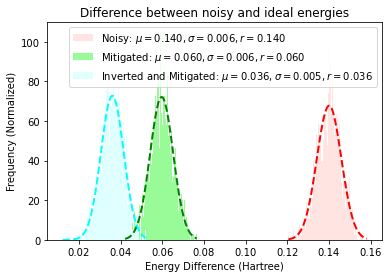

In [12]:
from Plot_Data import stats, plotter
colors = ['mistyrose', 'red', 'palegreen', 'green', 'lightcyan', 'cyan']
plotter(diff_r,diff_nr,diff_inr, colors , 'Restricted_Full.png')

# Without Readout